In [1]:
import pandas as pd
from pandas import HDFStore, DataFrame
import os
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import re
import random
import sklearn
import glob
import geopy.distance
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
import typhon
from typhon.retrieval.qrnn import QRNN
from math import radians, cos, sin, asin, sqrt

/home/teodor/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def calculate_errors(preds,labels):
        errors = np.zeros(len(preds))
        mse = 0

        for i in range(0,len(labels)):
            corr_val = labels[i]
            errors[i] = preds[i] - corr_val
            mse = mse + errors[i]**2
    
        return errors, mse/len(preds)

def print_confusion_matrix(preds, labels, threshold):
    rain_rain = 0
    rain_no_rain = 0
    no_rain_rain = 0
    no_rain_no_rain = 0
    
    for i in range(0,len(labels)):
        data_DPR_tmp = labels[i]
        preds_tmp = preds[i]
        if data_DPR_tmp > threshold and preds_tmp > threshold:
            rain_rain = rain_rain + 1
        if data_DPR_tmp > threshold and preds_tmp < threshold:
            rain_no_rain = rain_no_rain + 1
        if data_DPR_tmp < threshold and preds_tmp > threshold:
            no_rain_rain = no_rain_rain + 1
        if data_DPR_tmp < threshold and preds_tmp < threshold:
            no_rain_no_rain = no_rain_no_rain + 1
        
    print('------------------------------')
    print('           Rain      |   No rain')
    print('---------------------------------')
    print('Rain    |  ' + str(rain_rain) + '     |   ' + str(rain_no_rain))
    print('---------------------------------')
    print('No rain |  ' + str(no_rain_rain) + '     |   ' + str(no_rain_no_rain))
    print('')
    print('')
    return rain_rain, rain_no_rain, no_rain_rain, no_rain_no_rain

def print_max_and_min(errors):
    print(np.max(errors))
    print(np.min(errors))
    return

def get_calibration_plot_data(qrnn_preds,labels,threshold):
    #threshold = 0.1
    rain_inds = np.where(labels > threshold)[0]
    

    # CALIBRATION PLOT
    left_of_01 = 0
    left_of_03 = 0
    left_of_05 = 0
    left_of_07 = 0
    left_of_09 = 0

    for i in range(0,len(rain_inds)):
        corr_val = labels[rain_inds[i]]
        tmp_01 = qrnn_preds[rain_inds[i],1]
        tmp_03 = qrnn_preds[rain_inds[i],3]
        tmp_05 = qrnn_preds[rain_inds[i],5]
        tmp_07 = qrnn_preds[rain_inds[i],7]
        tmp_09 = qrnn_preds[rain_inds[i],9]
        if corr_val < tmp_01:
            left_of_01 = left_of_01 + 1
        if corr_val < tmp_03:
            left_of_03 = left_of_03 + 1
        if corr_val < tmp_05:
            left_of_05 = left_of_05 + 1
        if corr_val < tmp_07:
            left_of_07 = left_of_07 + 1
        if corr_val < tmp_09:
            left_of_09 = left_of_09 + 1

    observed_quantiles = np.zeros(5)
    observed_quantiles[0] = left_of_01
    observed_quantiles[1] = left_of_03
    observed_quantiles[2] = left_of_05
    observed_quantiles[3] = left_of_07
    observed_quantiles[4] = left_of_09
    
    return observed_quantiles / len(rain_inds)

def HSS(r_r, r_nr, nr_r, nr_nr):
    tmp_1 = 2 * (r_r * nr_nr - r_nr * nr_r)
    tmp_2 = (r_r + r_nr) * (r_nr + nr_nr) + (r_r + nr_r) * (nr_r + nr_nr)
    return tmp_1 / tmp_2

def MAPE(qrnn_05, labels):
    n = len(labels)
    abs_errors = 0
    for i in range(0,n):
        abs_errors = abs_errors + np.abs((labels[i] - qrnn_05[i]))
    
    mape = (1/n) * abs_errors
    return mape

def closest_quantile_to_threshold(preds, threshold):
    closest_quantile = 0
    for i in range(0,len(preds)):
        tmp_pred = preds[i]
        if tmp_pred < threshold and closest_quantile < 8:
            closest_quantile = closest_quantile + 1
    return closest_quantile

def get_mean_percentages_QRNN(preds,inds,threshold):
    pred_quantiles = []
    for i in inds:
        tmp_preds = preds[i]
        tmp_ind = closest_quantile_to_threshold(tmp_preds, threshold)
        pred_quantiles.append(quantiles[tmp_ind])
        
        pred_quantiles = 1 - np.array(pred_quantiles)
        return 100 * np.mean(pred_quantiles)
    
def get_conf_intervals(preds,labels,threshold):
    #rain_inds = np.where(labels > threshold)[0] 
    rain_inds = np.where(preds > threshold)[0] 

    quant_ind_1 = 3
    quant_ind_2 = 6
    conf_interval_lengths = []
    label_in_interval = []
    for j in range(0,len(rain_inds)):
        i = rain_inds[j]
        quant_end = preds[i,quant_ind_2]
        quant_start = preds[i,quant_ind_1]
        tmp_len = quant_end - quant_start
        conf_interval_lengths.append(tmp_len)
        if np.logical_and(labels[i] >= quant_start, labels[i] <= quant_end):
            label_in_interval.append(1)
        else:
            label_in_interval.append(0)
    
    frac_corr = np.sum(label_in_interval) / len(rain_inds)
    return conf_interval_lengths, label_in_interval, frac_corr

def pre_process_test_data(input_arr, output_arr, gprof_arr):
    # Remove artefacts from data
    for i in range(0,13):
        delete_inds = np.where(input_arr[:,i] > 500)
        input_arr = np.delete(input_arr, (delete_inds), axis = 0)
        output_arr = np.delete(output_arr, (delete_inds), axis = 0)
        gprof_arr = np.delete(gprof_arr, (delete_inds), axis = 0)
        
    for i in range(0,input_arr.shape[1]):
        delete_inds = np.where(input_arr[:,i] < 0)
        input_arr = np.delete(input_arr, (delete_inds), axis = 0)
        output_arr = np.delete(output_arr, (delete_inds), axis = 0)
        gprof_arr = np.delete(gprof_arr, (delete_inds), axis = 0)
        
    # Rounding the TCWV and T2m
    input_arr[:,13] = np.around(input_arr[:,13])
    input_arr[:,14] = np.around(input_arr[:,14])
    
    return input_arr, output_arr, gprof_arr

def qrnn_PoP(qrnn_preds, threshold, quantiles):
    PoP = 100 * (1 - quantiles[closest_quantile_to_threshold(qrnn_preds, threshold)])
    return PoP

In [3]:
input_path   = '/home/teodor/Documents/QRNN_GPM_project/database_testing/qrnn_input'
gprof_path   = '/home/teodor/Documents/QRNN_GPM_project/database_testing/gprof_retrievals'
gt_path      = '/home/teodor/Documents/QRNN_GPM_project/database_testing/ground_truth'
qrnn_files   = np.sort(glob.glob(input_path + '/*.txt'))
gprof_files  = np.sort(glob.glob(gprof_path + '/*.txt'))
gt_files     = np.sort(glob.glob(gt_path + '/*.txt'))

print(len(gt_files))

173


In [4]:
qrnn_input    = np.loadtxt(qrnn_files[0])
GPROF_output  = np.loadtxt(gprof_files[0])
ground_truth  = np.loadtxt(gt_files[0])

files = np.random.choice(np.arange(0,len(gt_files)),1)
for i in files:#range(1,len(qrnn_files),1):
    qrnn_input_tmp    = np.loadtxt(qrnn_files[i])
    GPROF_output_tmp  = np.loadtxt(gprof_files[i])
    ground_truth_tmp  = np.loadtxt(gt_files[i])
    
    qrnn_input   = np.concatenate((qrnn_input, qrnn_input_tmp), axis = 0)
    GPROF_output = np.concatenate((GPROF_output, GPROF_output_tmp), axis = 0)
    ground_truth = np.concatenate((ground_truth, ground_truth_tmp), axis = 0)
    if np.mod(i,4) == 0:
        print(len(qrnn_input))

In [5]:
# REMOVE ANY STRANGE INPUTS
print(qrnn_input.shape)
for i in range(0,13):
    tmp = qrnn_input[:,i]
    del_inds = np.where(tmp > 600)
    qrnn_input = np.delete(qrnn_input, (del_inds), axis = 0)
    GPROF_output = np.delete(GPROF_output, (del_inds), axis = 0)
    ground_truth = np.delete(ground_truth, (del_inds), axis = 0)
    
for i in range(0,15):
    tmp = qrnn_input[:,i]
    del_inds = np.where(tmp < 0)
    qrnn_input = np.delete(qrnn_input, (del_inds), axis = 0)
    GPROF_output = np.delete(GPROF_output, (del_inds), axis = 0)
    ground_truth = np.delete(ground_truth, (del_inds), axis = 0)
print(qrnn_input.shape)

(63554, 15)
(63529, 15)


In [6]:
# Prepare different input vectors for predicting
labels = ground_truth[:,0]
lons = ground_truth[:,1]
lats = ground_truth[:,2]
x_test = qrnn_input
GPROF_033 = GPROF_output[:,2]
GPROF_066 = GPROF_output[:,3]
GPROF_data = GPROF_output[:,0]
GPROF_PoP = GPROF_output[:,4]

In [7]:
# Load all networks
name_1 = "TEST_peridot"
#name_2 = "qrnn_12_128_iteration_6"
#name_3 = "qrnn_12_128_iteration_11"
qrnn_1 = QRNN.load(name_1)
#qrnn_2 = QRNN.load(name_2)
#qrnn_3 = QRNN.load(name_3)

In [8]:
# Make predictions
quantile_nbr = 5
qrnn_preds_1 = qrnn_1.predict(x_test)
qrnn_05_1 = np.copy(qrnn_preds_1[:,quantile_nbr])
#print('One done')
#qrnn_preds_2 = qrnn_2.predict(x_test)
#qrnn_05_2 = np.copy(qrnn_preds_2[:,quantile_nbr])
#print('Two done')
#qrnn_preds_3 = qrnn_3.predict(x_test)
#qrnn_05_3 = np.copy(qrnn_preds_3[:,quantile_nbr])
#print('Three done')

In [9]:
print(np.max(labels))
print(name_1 + ':               ' + str(np.max(qrnn_05_1)))
#print(name_2 + ':   ' + str(np.max(qrnn_05_2)))
#print(name_3 + ':   ' + str(np.max(qrnn_05_3)))
print('GPROF:                     ' + str(np.max(GPROF_data)))

27.365510940551758
TEST_peridot:               0.01369895
GPROF:                     18.04248809814453


In [13]:
errors_1, mse_1 = calculate_errors(qrnn_05_1,labels)
errors_2, mse_2 = calculate_errors(qrnn_05_2,labels)
errors_3, mse_3 = calculate_errors(qrnn_05_3,labels)
errors_GPROF, mse_GPROF = calculate_errors(GPROF_data, labels)
print(name_1 + ': ' + str(mse_1))
print(name_2 + ': ' + str(mse_2))
print(name_3 + ': ' + str(mse_3))
print('MSE GPROF: ' + str(mse_GPROF))

qrnn_12_128_iteration_4: 0.06417421677178746
qrnn_12_128_iteration_6: 0.06560148640397065
qrnn_12_128_iteration_11: 0.06344766722734613
MSE GPROF: 0.08813366895659806


In [27]:
threshold = 0.01
# Print confusion matrices
#print(name_1)
#rain_rain_1, rain_no_rain_1, no_rain_rain_1, no_rain_no_rain_1 = print_confusion_matrix(qrnn_05_1, labels, threshold)
print(name_2)
rain_rain_2, rain_no_rain_2, no_rain_rain_2, no_rain_no_rain_2 = print_confusion_matrix(qrnn_05_2, labels, threshold)
print(name_3)
rain_rain_3, rain_no_rain_3, no_rain_rain_3, no_rain_no_rain_3 = print_confusion_matrix(qrnn_05_3, labels, threshold)
print('     GPROF')
rain_rain_GPROF, rain_no_rain_GPROF, no_rain_rain_GPROF, no_rain_no_rain_GPROF = print_confusion_matrix(GPROF_data, labels, threshold)

qrnn_12_128_iteration_1
------------------------------
           Rain      |   No rain
---------------------------------
Rain    |  417309     |   215558
---------------------------------
No rain |  86497     |   2639394


qrnn_12_128_iteration_4
------------------------------
           Rain      |   No rain
---------------------------------
Rain    |  436816     |   196051
---------------------------------
No rain |  81937     |   2643954


     GPROF
------------------------------
           Rain      |   No rain
---------------------------------
Rain    |  571722     |   61145
---------------------------------
No rain |  1167232     |   1558659




In [28]:
rain_inds = np.where(labels > threshold)

#mape_1 = MAPE(qrnn_05_1[rain_inds], labels[rain_inds])
mape_2 = MAPE(qrnn_05_2[rain_inds], labels[rain_inds])
mape_3 = MAPE(qrnn_05_3[rain_inds], labels[rain_inds])
mape_GPROF = MAPE(GPROF_data[rain_inds], labels[rain_inds])

#HSS_1 = HSS(rain_rain_1, rain_no_rain_1, no_rain_rain_1, no_rain_no_rain_1)
HSS_2 = HSS(rain_rain_2, rain_no_rain_2, no_rain_rain_2, no_rain_no_rain_2)
HSS_3 = HSS(rain_rain_3, rain_no_rain_3, no_rain_rain_3, no_rain_no_rain_3)
HSS_GPROF = HSS(rain_rain_GPROF, rain_no_rain_GPROF, no_rain_rain_GPROF, no_rain_no_rain_GPROF)

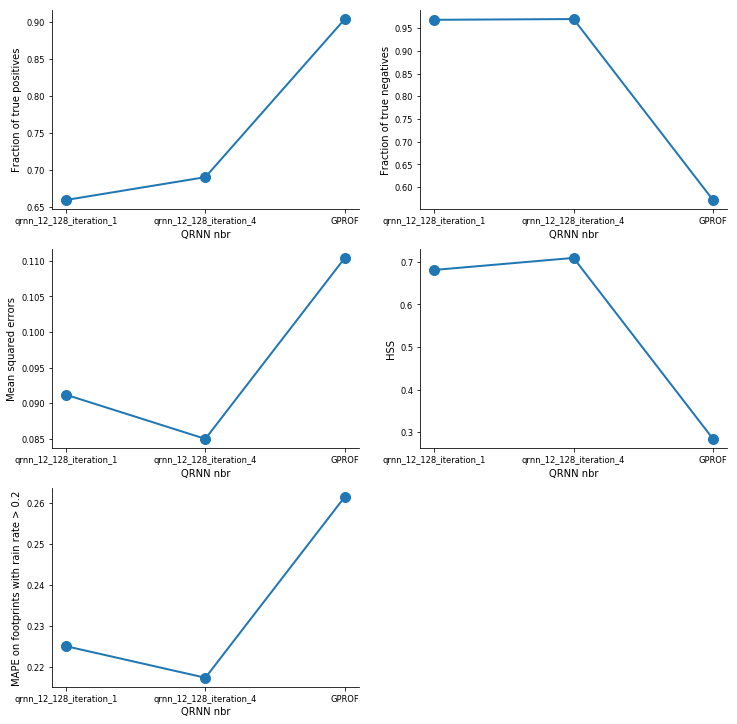

In [29]:
n_neighbours = [0,4,8,12,16,18]
rain_rains = np.array([rain_rain_2, rain_rain_3,rain_rain_GPROF]) / len(labels[labels > threshold]) # FOR 2
#rain_rains = np.array([rain_rain_1, rain_rain_2, rain_rain_3,rain_rain_GPROF]) / len(labels[labels > threshold])
no_rain_no_rains = np.array([no_rain_no_rain_2,no_rain_no_rain_3,no_rain_no_rain_GPROF]) / len(labels[labels < threshold])
#no_rain_no_rains= np.array([no_rain_no_rain_1,no_rain_no_rain_2,no_rain_no_rain_3,no_rain_no_rain_GPROF]) / len(labels[labels < threshold])
mses = [mse_2, mse_3, mse_GPROF]
#mses = [mse_1, mse_2, mse_3, mse_GPROF]
HSS_scores = [HSS_2, HSS_3,HSS_GPROF]
#HSS_scores = [HSS_1, HSS_2, HSS_3,HSS_GPROF]
mape_scores = [mape_2, mape_3, mape_GPROF]
#mape_scores= [mape_1, mape_2, mape_3, mape_GPROF]
start_ind = 0
end_ind = 3

plt.figure(figsize = (5,5))
ax1 = plt.subplot(3,2,1)
plt.plot(n_neighbours[start_ind:end_ind], rain_rains[start_ind:end_ind], marker='o')
plt.xlabel('QRNN nbr')
plt.ylabel('Fraction of true positives')
plt.xticks([0,4,8],[name_2,name_3,'GPROF'])

ax1 = plt.subplot(3,2,2)
plt.plot(n_neighbours[start_ind:end_ind], no_rain_no_rains[start_ind:end_ind], marker = 'o')
plt.xlabel('QRNN nbr')
plt.ylabel('Fraction of true negatives')
plt.xticks([0,4,8],[name_2,name_3,'GPROF'])

ax1 = plt.subplot(3,2,3)
plt.plot(n_neighbours[start_ind:end_ind], mses[start_ind:end_ind], marker = 'o')
plt.xlabel('QRNN nbr')
plt.ylabel('Mean squared errors')
plt.xticks([0,4,8],[name_2,name_3,'GPROF'])

ax1 = plt.subplot(3,2,4)
plt.plot(n_neighbours[start_ind:end_ind], HSS_scores[start_ind:end_ind] , marker = 'o')
plt.xlabel('QRNN nbr')
plt.ylabel('HSS')
plt.xticks([0,4,8],[name_2,name_3,'GPROF'])
plt.subplots_adjust(bottom = -1)
plt.subplots_adjust(right = 2)

ax1 = plt.subplot(3,2,5)
plt.plot(n_neighbours[start_ind:end_ind], mape_scores[start_ind:end_ind] , marker = 'o')
plt.xlabel('QRNN nbr')
plt.ylabel('MAPE on footprints with rain rate > 0.2')
plt.xticks([0,4,8],[name_2,name_3,'GPROF'])
plt.subplots_adjust(bottom = -1)
plt.subplots_adjust(right = 2)

plt.show()

In [30]:
print(name_2 + '   ' + name_3 + '   GPROF')
print(rain_rains)
print(no_rain_no_rains)
#print(threshold)
#print(rain_rain_3/len(labels[labels > threshold]))
#print(rain_rain_GPROF/len(labels[labels > threshold]))

#print(no_rain_no_rain_3/len(labels[labels < threshold]))
#print(no_rain_no_rain_GPROF/len(labels[labels < threshold]))

qrnn_12_128_iteration_1   qrnn_12_128_iteration_4   GPROF
[0.65939447 0.69021769 0.90338412]
[0.96826836 0.9699412  0.57179799]


In [35]:
threshold = 1000000000000000
min_val = -1#np.min([errors_05, errors_05_2, errors_GPROF])
max_val = 1#np.max([errors_05, errors_05_2, errors_GPROF])

no_rain_inds = np.where(labels < threshold)[0]

n_bins = 15000

plt.figure(figsize=(15,8))
bins_all = np.linspace(min_val,max_val,n_bins)
#n_1,x_1,_ = plt.hist(errors_1[no_rain_inds],bins=bins_all, normed=True);
n_2,x_2,_ = plt.hist(errors_2[no_rain_inds],bins=bins_all, normed=True);
n_3,x_3,_ = plt.hist(errors_3[no_rain_inds],bins=bins_all, normed=True);
n_GPROF,x_GPROF,_ = plt.hist(errors_GPROF[no_rain_inds],bins=bins_all, normed=True)

plt.clf()

#bin_centers_1 = 0.5*(x_1[1:]+x_1[:-1])
bin_centers_2 = 0.5*(x_2[1:]+x_2[:-1])
bin_centers_3 = 0.5*(x_3[1:]+x_3[:-1])
bin_centers_GPROF = 0.5*(x_GPROF[1:]+x_GPROF[:-1])

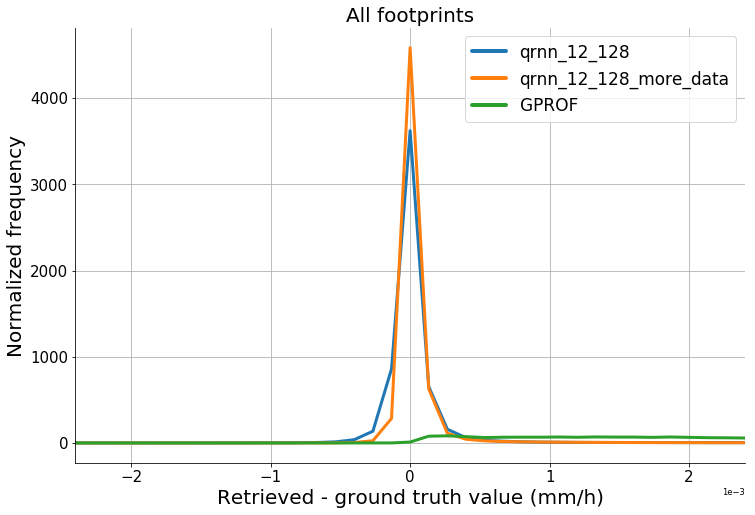

In [38]:
plt.figure(figsize=(12,8))
linew = 3
a = 8
#plt.plot(bin_centers_1,n_1,label=name_1, lw = linew)
plt.plot(bin_centers_2,n_2,label=name_2, lw = linew)
plt.plot(bin_centers_3,n_3,label=name_3, lw = linew)
plt.plot(bin_centers_GPROF,n_GPROF,label='GPROF', lw = linew)
plt.xlim([-0.0003*a,0.0003*a])
label_font = 20
tick_s = 15
plt.ylabel('Normalized frequency', fontsize = label_font)
plt.xlabel('Retrieved - ground truth value (mm/h)', fontsize = label_font)
plt.title('All footprints', fontsize = label_font)
plt.xticks(fontsize=tick_s)
plt.yticks(fontsize=tick_s)
leg = plt.legend(prop={'size': 17})
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=4)
plt.grid()
plt.show()

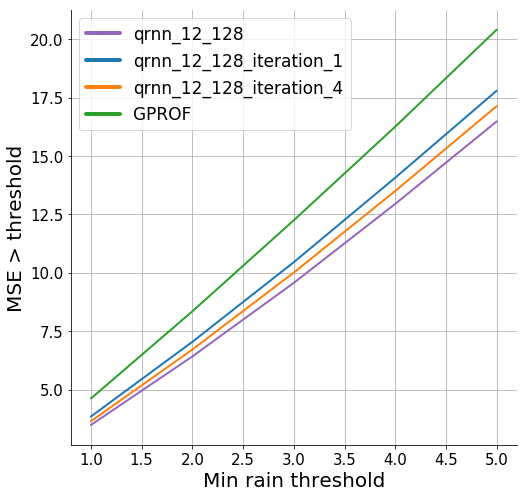

In [34]:
mses_1 = []
mses_2 = []
mses_3 = []
mses_GPROF = []
thresholds = [1,2,3,4,5]
for i in range(0,len(thresholds)):
    rain_inds = np.where(labels > thresholds[i])
    _, mse_1 = calculate_errors(qrnn_05_1[rain_inds],labels[rain_inds])
    _, mse_2 = calculate_errors(qrnn_05_2[rain_inds],labels[rain_inds])
    _, mse_3 = calculate_errors(qrnn_05_3[rain_inds],labels[rain_inds])
    _, mse_GPROF = calculate_errors(GPROF_data[rain_inds],labels[rain_inds])
    
    mses_1.append(mse_1)
    mses_2.append(mse_2)
    mses_3.append(mse_3)
    mses_GPROF.append(mse_GPROF)

plt.figure(figsize=(8,8))
plt.plot(thresholds, mses_1, label = name_1,color = 'C4')
plt.plot(thresholds, mses_2, label = name_2, color = 'C0')
plt.plot(thresholds, mses_3, label = name_3, color = 'C1')
plt.plot(thresholds, mses_GPROF, label = 'GPROF', color = 'C2')
label_font = 20
tick_s = 15
plt.xlabel('Min rain threshold', fontsize = label_font)
plt.ylabel('MSE > threshold', fontsize = label_font)
plt.xticks(fontsize=tick_s)
plt.yticks(fontsize=tick_s)
leg = plt.legend(prop={'size': 17})
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=4)
plt.grid()
plt.show()

In [14]:
threshold = 1
min_val = -100#np.min([errors_05, errors_05_2, errors_GPROF])
max_val = 100#np.max([errors_05, errors_05_2, errors_GPROF])

no_rain_inds = np.where(labels > threshold)[0]
print(len(no_rain_inds))

n_bins = 3000

plt.figure(figsize=(15,8))
bins_all = np.linspace(min_val,max_val,n_bins)
n_1,x_1,_ = plt.hist(errors_1[no_rain_inds],bins=bins_all, normed=True);
n_2,x_2,_ = plt.hist(errors_2[no_rain_inds],bins=bins_all, normed=True);
n_3,x_3,_ = plt.hist(errors_3[no_rain_inds],bins=bins_all, normed=True);
n_GPROF,x_GPROF,_ = plt.hist(errors_GPROF[no_rain_inds],bins=bins_all, normed=True)

plt.clf()

bin_centers_1 = 0.5*(x_1[1:]+x_1[:-1])
bin_centers_2 = 0.5*(x_2[1:]+x_2[:-1])
bin_centers_3 = 0.5*(x_3[1:]+x_3[:-1])
bin_centers_GPROF = 0.5*(x_GPROF[1:]+x_GPROF[:-1])

47353


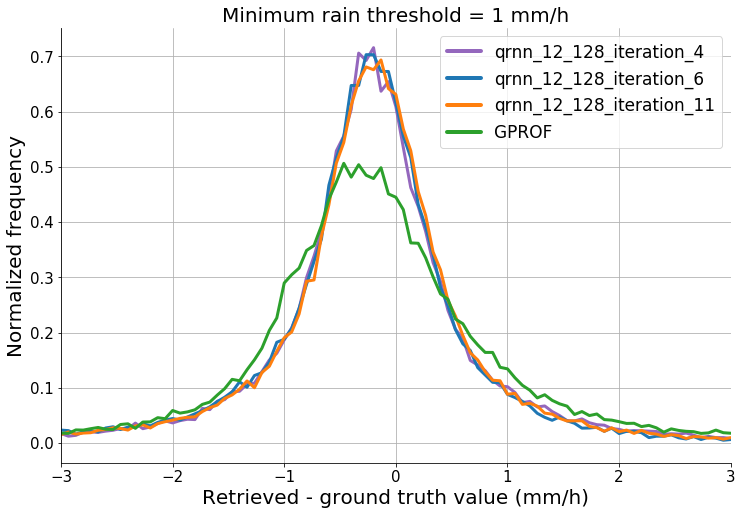

In [15]:
linew = 3
a = 100
plt.figure(figsize=(12,8))
plt.plot(bin_centers_1,n_1,label=name_1, lw = linew, color = 'C4')
plt.plot(bin_centers_2,n_2,label=name_2, lw = linew, color = 'C0')
plt.plot(bin_centers_3,n_3,label=name_3, lw = linew, color = 'C1')
plt.plot(bin_centers_GPROF,n_GPROF,label='GPROF', lw = linew, color = 'C2')
plt.xlim([-0.03*a,0.03*a])
label_font = 20
tick_s = 15
plt.ylabel('Normalized frequency', fontsize = label_font)
plt.xlabel('Retrieved - ground truth value (mm/h)', fontsize = label_font)
plt.title('Minimum rain threshold = ' + str(threshold) + ' mm/h', fontsize = label_font)
plt.xticks(fontsize=tick_s)
plt.yticks(fontsize=tick_s)
leg = plt.legend(prop={'size': 17})
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=4)
plt.grid()
plt.show()

In [16]:
# CALCULATE CALIBRATION PLOT DATA
threshold = -1
obs_quants_1 = get_calibration_plot_data(qrnn_preds_1,labels,threshold)
obs_quants_2 = get_calibration_plot_data(qrnn_preds_2,labels,threshold)
obs_quants_3 = get_calibration_plot_data(qrnn_preds_3,labels,threshold)

# CALIBRATION DATA FOR GPROF
left_of_033 = 0
left_of_066 = 0

rain_inds  = np.where(labels > threshold)[0]

for j in range(0,len(rain_inds)):
    i = rain_inds[j]
    corr_val = labels[i]
    
    if corr_val < GPROF_033[i]:
        left_of_033 = left_of_033 + 1
    if corr_val < GPROF_066[i]:
        left_of_066 = left_of_066 + 1

obs_quants_GPROF = np.zeros(2)
obs_quants_GPROF[0] = left_of_033
obs_quants_GPROF[1] = left_of_066

obs_quants_GPROF = obs_quants_GPROF / len(labels)

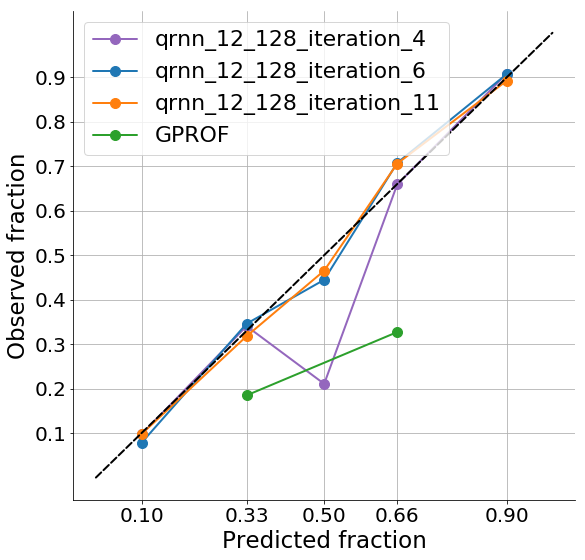

In [17]:
# CALIBRATION PLOT
labelsize = 23
ticksize = 20


x = np.array([0.1,0.33,0.5,0.66,0.9])
x_GPROF = np.array([0.33,0.66])
plt.figure(figsize=(9,9))
plt.plot(x,obs_quants_1,marker='o',label=name_1, color = 'C4')
plt.plot(x,obs_quants_2,marker='o',label=name_2, color = 'C0')
plt.plot(x,obs_quants_3,marker='o',label=name_3, color = 'C1')
plt.plot(x_GPROF, obs_quants_GPROF, marker='o', label='GPROF', color = 'C2')
plt.plot([0,1],[0,1],linestyle = '--',color='black')
plt.xlabel('Predicted fraction', fontsize = labelsize)
plt.ylabel('Observed fraction', fontsize = labelsize)
plt.xticks([0.1,0.33,0.5,0.66,0.9], fontsize = ticksize)
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize = ticksize)

plt.legend(fontsize = 22)
plt.grid()
plt.show()

In [34]:
qrnn_preds_2[qrnn_preds_2 < 0] = 0

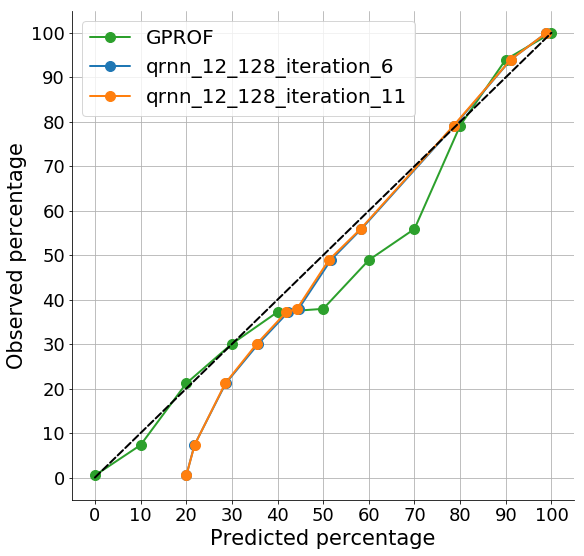

In [18]:
threshold = 0.01

actual_percentages = []
mean_pred_quantiles = []
mean_pred_quantiles_2 = []
probs = [0,10,20,30,40,50,60,70,80,90,100]
for j in range(0,len(probs)):
    probability = probs[j]
    inds = np.where(GPROF_PoP == probability)[0]
    rain_sum = 0
    for i in inds:
        tmp_label = labels[i]
        if tmp_label > threshold:
            rain_sum = rain_sum + 1

    quantiles = [0.01, 0.1, 0.2, 0.33, 0.4, 0.5, 0.66, 0.7, 0.8, 0.9, 0.99]
    pred_quantiles = []
    pred_quantiles_2 = []
    for i in inds:
        tmp_preds = qrnn_preds_2[i]
        tmp_preds_2 = qrnn_preds_3[i]
        tmp_ind = closest_quantile_to_threshold(tmp_preds, threshold)
        tmp_ind_2 = closest_quantile_to_threshold(tmp_preds_2, threshold)
        pred_quantiles.append(quantiles[tmp_ind])
        pred_quantiles_2.append(quantiles[tmp_ind_2])
    
    pred_quantiles = 1 - np.array(pred_quantiles)
    pred_quantiles_2 = 1 - np.array(pred_quantiles_2)

    actual_percentages.append(100 * rain_sum / len(inds))
    mean_pred_quantiles.append(100 * np.mean(pred_quantiles))
    mean_pred_quantiles_2.append(100 * np.mean(pred_quantiles_2))
    
probs_2 = [0,10,20,30,40,50,60,70,80,90,100]
plt.figure(figsize=(9,9))

labelsize = 21
ticksize = 18
linew = 2
plt.plot(probs,actual_percentages, marker= 'o', label= 'GPROF', color = 'C2', linewidth = linew)
plt.plot(mean_pred_quantiles,actual_percentages, marker = 'o',label = name_2,color='C0', linewidth = linew)
plt.plot(mean_pred_quantiles_2,actual_percentages, marker = 'o',label = name_3,color='C1', linewidth = linew)

plt.plot(probs_2,probs_2,linestyle = '--', c = 'black', linewidth = linew)
plt.legend(fontsize = 20)
plt.xlabel('Predicted percentage',fontsize = labelsize)
plt.ylabel('Observed percentage',fontsize = labelsize)
plt.xticks(probs_2, fontsize = ticksize)
plt.yticks(probs_2, fontsize = ticksize)
plt.grid()

plt.show()

In [19]:
thresh = [0.0]#[0.01,0.2,0.6,1,2,3,5,8,10]
#thresh = [1]
nbr_of_rain_inds = []
#mean_confs_1 = []
mean_confs_2 = []
mean_confs_3 = []
GPROF_confs = []

#fracs_corr_1 = []
fracs_corr_2 = []
fracs_corr_3 = []
fracs_corr_GPROF = []
for l in range(0,len(thresh)):
    threshold = thresh[l]
    #conf_ints_1, label_in_int_1, frac_corr_1 = get_conf_intervals(qrnn_preds_1, labels, threshold)
    conf_ints_2, label_in_int_2, frac_corr_2 = get_conf_intervals(qrnn_preds_2, labels, threshold)
    conf_ints_3, label_in_int_3, frac_corr_3 = get_conf_intervals(qrnn_preds_3, labels, threshold)

    # GET CONFIDENCE INTERVAL USING GPROF 0.33th and 0.66th quantiles
    #rain_inds = np.where(labels > threshold)[0]
    rain_inds = np.where(GPROF_data > threshold)[0]
    conf_lens_GRPOF = []
    label_in_int_GPROF = []
    points_est_in_int = []
    for j in range(0,len(rain_inds)):
        i = rain_inds[j]
        quant_end = GPROF_066[i]
        quant_start = GPROF_033[i]
        tmp_len = quant_end - quant_start
        conf_lens_GRPOF.append(tmp_len)

        if np.logical_and(labels[i] > quant_start, labels[i] < quant_end):
            label_in_int_GPROF.append(1)
        else:
            label_in_int_GPROF.append(0)
        
        # CHECK HOW OFTEN THE POINT ESTIMATE IS IN CONF INT.
        if np.logical_and(GPROF_data[i] > quant_start, GPROF_data[i] < quant_end):
            points_est_in_int.append(1)
        else:
            points_est_in_int.append(0)
            
    n_corr_GPROF = np.sum(label_in_int_GPROF)
    
    #mean_confs_1.append(np.mean(conf_ints_1))
    mean_confs_2.append(np.mean(conf_ints_2))
    mean_confs_3.append(np.mean(conf_ints_3))
    GPROF_confs.append(np.mean(conf_lens_GRPOF))
    
    #fracs_corr_1.append(frac_corr_1)
    fracs_corr_2.append(frac_corr_2)
    fracs_corr_3.append(frac_corr_3)
    fracs_corr_GPROF.append(n_corr_GPROF / len(rain_inds))
    
    nbr_of_rain_inds.append(len(rain_inds))


In [42]:
#print(name_1 + 'frac corr: ' + str(frac_corr_1) )
print(name_2 + 'frac corr: ' + str(frac_corr_2) )
print(name_3 + 'frac corr: ' + str(frac_corr_3) )
print('GPROF: ' + str(fracs_corr_GPROF))

qrnn_12_128_iteration_1frac corr: 0.14705195960876868
qrnn_12_128_iteration_4frac corr: 0.44345280515855195
GPROF: [0.025108537790086635]


In [43]:
min_len = 0
max_len = 12
n_bins = 600

plt.figure(figsize=(15,8))
bins_all = np.linspace(min_len,max_len,n_bins)
#n_1,x_1,_ = plt.hist(conf_ints_1,bins=bins_all, normed=True);
n_2,x_2,_ = plt.hist(conf_ints_2,bins=bins_all, normed=True);
n_3,x_3,_ = plt.hist(conf_ints_3,bins=bins_all, normed=True);
n_GPROF,x_GPROF,_ = plt.hist(conf_lens_GRPOF,bins=bins_all, normed=True);
#plt.xlim([0,0.6])
#plt.show()

plt.clf()

#bin_centers_1 = 0.5*(x_1[1:]+x_1[:-1])
bin_centers_2 = 0.5*(x_2[1:]+x_2[:-1])
bin_centers_3 = 0.5*(x_3[1:]+x_3[:-1])
bin_centers_GPROF = 0.5*(x_GPROF[1:]+x_GPROF[:-1])

In [44]:
def get_correct_by_bins(conf_ints, label_in_int,top_bound):
    interval_size  = 0.05
    conf_ints = np.array(conf_ints)
    lower_bounds = np.arange(0,top_bound,interval_size)
    upper_bounds = lower_bounds + interval_size
    bound_mids = (lower_bounds + upper_bounds) / 2

    fractions_of_correct = []

    for k in range(0,len(lower_bounds)):
        low_bound = lower_bounds[k]
        up_bound = upper_bounds[k]
        conf_inds = np.where(np.logical_and(conf_ints > low_bound,conf_ints < up_bound))[0]

        corr_sum = 0
        for j in range(0,len(conf_inds)):
            i = conf_inds[j]
            corr_sum = corr_sum + label_in_int[i]

        frac_corr = corr_sum / len(conf_inds)
        fractions_of_correct.append(frac_corr)
        
    return fractions_of_correct, bound_mids, upper_bounds

In [45]:
top_bound = 0.4
#fracs_of_corr_1, bound_mids, _ = get_correct_by_bins(conf_ints_1, label_in_int_1,top_bound)
fracs_of_corr_2, bound_mids, _ = get_correct_by_bins(conf_ints_2, label_in_int_2,top_bound)
fracs_of_corr_3, bound_mids, _ = get_correct_by_bins(conf_ints_3, label_in_int_3,top_bound)
fracs_of_corr_GPROF, bound_mids, upper_bounds = get_correct_by_bins(conf_lens_GRPOF, label_in_int_GPROF,top_bound) 

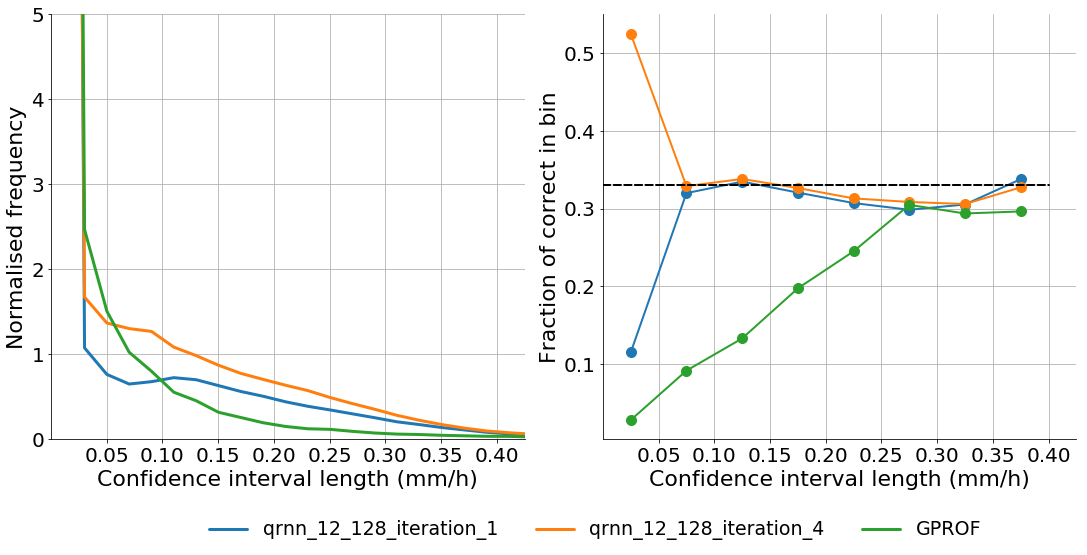

In [46]:
fig, axes = plt.subplots(1, 2, figsize = (15,7))
ax1 = axes.flatten()[0]
ax2 = axes.flatten()[1]

xmax = bound_mids[-1] + 0.05
linew = 3
labelsize = 22
ticksize = 20

#ax1.plot(bin_centers_1,n_1,label=name_1, lw = linew, color = 'C0')
ax1.plot(bin_centers_2,n_2,label=name_2, lw = linew, color = 'C0')
ax1.plot(bin_centers_3,n_3,label=name_3, lw = linew, color = 'C1')
ax1.plot(bin_centers_GPROF,n_GPROF,label='GPROF', lw = linew, color = 'C2')
ax1.grid()
ax1.set_ylabel('Normalised frequency', fontsize = labelsize)
ax1.set_xlabel('Confidence interval length (mm/h)', fontsize = labelsize)
ax1.set_xlim([0,xmax])
ax1.tick_params(axis="x", labelsize=ticksize)
ax1.tick_params(axis="y", labelsize=ticksize)
ax1.set_ylim([0,5])
ax1.set_xticks(upper_bounds)

#ax2.plot(bound_mids, fracs_of_corr_1, marker = 'o', color = 'C0')
ax2.plot(bound_mids, fracs_of_corr_2, marker = 'o', color = 'C0')
ax2.plot(bound_mids, fracs_of_corr_3, marker = 'o', color = 'C1')
ax2.plot(bound_mids, fracs_of_corr_GPROF, marker = 'o', color = 'C2')
ax2.plot([0,top_bound],[0.33,0.33],linestyle = '--', color = 'black')

ax2.grid()
ax2.set_xlabel('Confidence interval length (mm/h)', fontsize = labelsize)
ax2.set_ylabel('Fraction of correct in bin', fontsize = labelsize)
ax2.set_xlim([0,xmax])
ax2.tick_params(axis="x", labelsize=ticksize)
ax2.tick_params(axis="y", labelsize=ticksize)
ax2.set_xticks(upper_bounds)

fig.tight_layout()
fig.subplots_adjust(right = 1)

ax1.legend(loc = 'best', bbox_to_anchor = (2.0, -0.15),
                      fancybox = True, ncol = 4, frameon = False, fontsize = 19)
plt.show()

In [39]:
training_output_path = '/home/teodor/Documents/QRNN_GPM_project/database_training/output' + '/*.txt'
database_outputs = []
output_list = np.sort(glob.glob(training_output_path))
for i in range(0,5):
    print('Importing batch ' + str(i+1))
    output_file = output_list[i]
    output_arr = np.loadtxt(output_file)
    database_outputs.extend(output_arr)

print(np.max(database_outputs))
print(np.max(labels))

n_bins = 6000
min_val = 0
max_val = 15#np.max([np.max(labels),np.max(database_outputs)])

plt.figure(figsize=(10,5))
bins_all = np.linspace(min_val,max_val,n_bins)
n_1,x_1,_ = plt.hist(labels,bins=bins_all, normed=True);
n_2,x_2,_ = plt.hist(database_outputs,bins=bins_all, normed=True);
#n_qrnn,x_qrnn,_ = plt.hist(qrnn_05_1,bins=bins_all,normed = True)
n_qrnn_2,x_qrnn_2,_ = plt.hist(qrnn_05_2,bins=bins_all,normed = True)
n_qrnn_3,x_qrnn_3,_ = plt.hist(qrnn_05_3,bins=bins_all,normed = True)
n_GPROF,x_GPROF,_ = plt.hist(GPROF_data,bins=bins_all,normed = True)
plt.clf()

bin_centers_1 = 0.5*(x_1[1:]+x_1[:-1])
bin_centers_2 = 0.5*(x_2[1:]+x_2[:-1])
#bin_centers_qrnn = 0.5*(x_qrnn[1:]+x_qrnn[:-1])
bin_centers_qrnn_2 = 0.5*(x_qrnn_2[1:]+x_qrnn_2[:-1])
bin_centers_qrnn_3 = 0.5*(x_qrnn_3[1:]+x_qrnn_3[:-1])
bin_centers_GPROF = 0.5*(x_GPROF[1:]+x_GPROF[:-1])

Importing batch 1
Importing batch 2
Importing batch 3
Importing batch 4
Importing batch 5
101.50733947753906
76.03741455078125


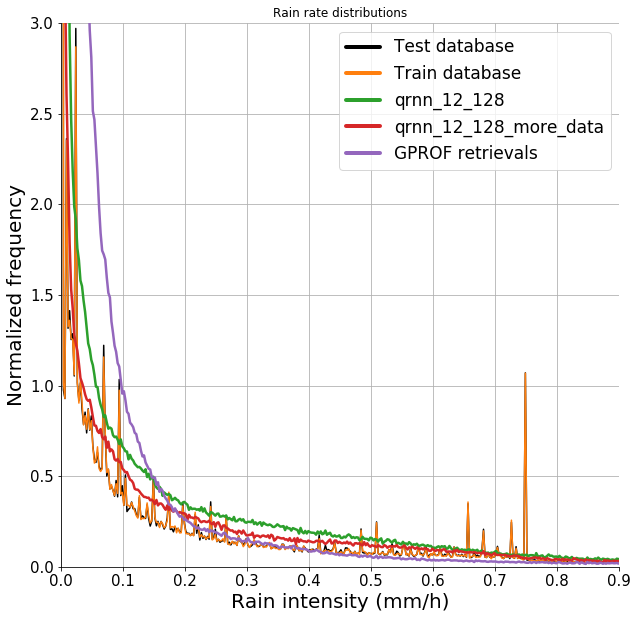

In [43]:
plt.figure(figsize=(10,10))
linew = 1.5
plt.plot(bin_centers_1,n_1,label='Test database', lw = linew, color = 'black')
plt.plot(bin_centers_2,n_2,label='Train database', lw = linew)
#plt.plot(bin_centers_qrnn,n_qrnn,label=name_1, lw=linew)
plt.plot(bin_centers_qrnn_2,n_qrnn_2,label=name_2, lw=linew + 1)
plt.plot(bin_centers_qrnn_3,n_qrnn_3,label=name_3, lw=linew + 1)
plt.plot(bin_centers_GPROF, n_GPROF, label = 'GPROF retrievals', lw = linew + 1)
plt.grid()
plt.xlim([0,0.9])
plt.ylim([0,3])
label_font = 20
tick_s = 15
plt.title('Rain rate distributions')
plt.ylabel('Normalized frequency', fontsize = label_font)
plt.xlabel('Rain intensity (mm/h)', fontsize = label_font)
plt.xticks(fontsize=tick_s)
plt.yticks(fontsize=tick_s)
leg = plt.legend(prop={'size': 17})
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=4)
plt.show()

In [49]:
def calculate_mean_rain_rates(lats, bin_width, rain_rates):
    low_bound = np.min(lats)
    top_bound = np.max(lats)
    
    lower_bounds = np.arange(low_bound,top_bound,bin_width)
    upper_bounds = lower_bounds + bin_width
    bound_mids = (lower_bounds + upper_bounds) / 2
    average_rain_rates = []
    
    for i in range(0,len(lower_bounds)):  
        low_bound = lower_bounds[i]
        up_bound = upper_bounds[i]
        inds = np.where(np.logical_and(lats > low_bound,lats < up_bound))[0]
        avg_rain_rate = np.mean(rain_rates[inds])
        average_rain_rates.append(avg_rain_rate)
    
    return bound_mids, average_rain_rates

In [50]:
bin_width = 1.5
bound_mids_GPROF, average_rain_rates_GPROF = calculate_mean_rain_rates(lats,bin_width,GPROF_data)
print('Two done')
bound_mids_labels, average_rain_rates_labels = calculate_mean_rain_rates(lats,bin_width,labels)
print('Three done')
bound_mids_2, average_rain_rates_2 = calculate_mean_rain_rates(lats,bin_width,qrnn_05_2)
print('Four done')
bound_mids_3, average_rain_rates_3 = calculate_mean_rain_rates(lats,bin_width,qrnn_05_3)
print('Five done')

Two done
Three done
Four done
Five done


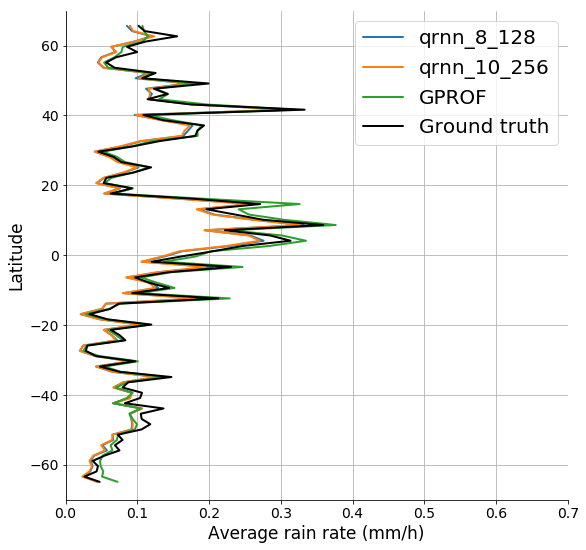

In [52]:
plt.figure(figsize=(9,9))

labelsize = 17
ticksize = 14
linew = 2

plt.plot(average_rain_rates_2,bound_mids_2, label = name_2, color = 'C0', linewidth = linew)
plt.plot(average_rain_rates_3,bound_mids_3, label = name_3, color = 'C1', linewidth = linew)
plt.plot(average_rain_rates_GPROF,bound_mids_GPROF, label = 'GPROF', color = 'C2', linewidth = linew)
plt.plot(average_rain_rates_labels,bound_mids_labels, label = 'Ground truth', color = 'black', linewidth = linew)
plt.legend(fontsize = 20)
plt.grid()
plt.xlabel('Average rain rate (mm/h)',fontsize = labelsize)
plt.ylabel('Latitude',fontsize = labelsize)
plt.xticks(fontsize = ticksize)
plt.yticks(fontsize = ticksize)
y_bound = 70
plt.ylim([-y_bound,y_bound])
plt.xlim([0,0.7])
plt.show()



In [ ]:
# Try to cut off predictions if chance of raining is low
threshold = 0.01
for i in range(0,len(labels)):
    #if qrnn_preds_1[i,8] < threshold:
    #    qrnn_05_1[i] = 0
    if qrnn_preds_2[i,8] < threshold:
        qrnn_05_2[i] = 0
    if qrnn_preds_3[i,8] < threshold:
        qrnn_05_3[i] = 0